In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

from cosmoprimo import *

from densitysplit import catalog_data, density_split
from densitysplit.split_model import *
from densitysplit.corr_func_utils import *
from densitysplit.utils import *

plt.style.use(os.path.join(os.path.abspath(''), 'densitysplit.mplstyle'))

# To activate logging
setup_logging()

In [2]:
plt.rcParams["figure.figsize"] = (10, 4)
plt.rcParams['figure.dpi'] = 500

## Global parameters

In [12]:
# Mock parameters
boxsize = 2000
boxcenter = 1000
nmesh = 1024
nbar = [0.001, 0.01]
cosmology=fiducial.AbacusSummitBase()
z = 1.175
bias = 1.8

# Mocks
nmocks = [10, 10]

# Density smoothing parameters
cellsize = 10
resampler = 'tsc'

## Gaussian mocks to compare to model

In [56]:
output_dir = '/feynman/work/dphp/mp270220/outputs/correlation_functions/'
name = ['{:d}gaussianMocks_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(nmocks[i], z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

## Initialize Gaussian model

In [5]:
model = [SplitCCFModel(redshift=z, cosmology=cosmology, bias=bias, nbar=nb) for nb in nbar]

/feynman/work/dphp/adematti/cosmodesiconda/20220713-1.0.0/code/cosmoprimo/main/lib/python3.9/site-packages/cosmoprimo/interpolator.py:517: ComplexWarning: Casting complex values to real discards the imaginary part
  k = np.asarray(k, dtype=dtype)


## $\xi_R(s)$

In [57]:
ells = [0]
nells = len(ells)

In [58]:
nb=0.001
i=0

xi_result = list()

for batch_index in range(10):
    batch_results = np.load(output_dir+name[i]+'_xi_R.npy', allow_pickle=True)
    for batch in batch_results:
        xi_result.append(batch)
        
xi_result2 = list()
name = ['{:d}gaussianMocks_batch0_pkdamped_z{:.3f}_bias{:.1f}_boxsize{:d}_nmesh{:d}_nbar{:.3f}_cellsize{:d}_resampler'.format(nmocks[i], z, bias, boxsize, nmesh, nb, cellsize)+resampler for (i, nb) in enumerate(nbar)]

for batch_index in range(10):
    batch_results = np.load(output_dir+name[i]+'_xi_R.npy', allow_pickle=True)
    for batch in batch_results:
        xi_result2.append(batch)

In [59]:
plt.rcParams['figure.dpi'] = 500

In [60]:
wfield = model[i].smoothing_kernel_3D.c2r() / model[i].boxsize**3
sep, mu, w = project_to_basis(wfield, edges=(model[i].s, np.array([-1., 1.])), exclude_zero=False)[0][:3]
shot_noise_correction = (1 + model[i].sigma**2) * w / model[i].nbar

In [61]:
xiR_test = ( (1 + model[i].sigma**2)/model[i].nbar * w + w[0]/model[i].nbar * (1 + model[i].xi) + 1 + model[i].xi_R) / (1 + w[0] / model[i].nbar) - 1

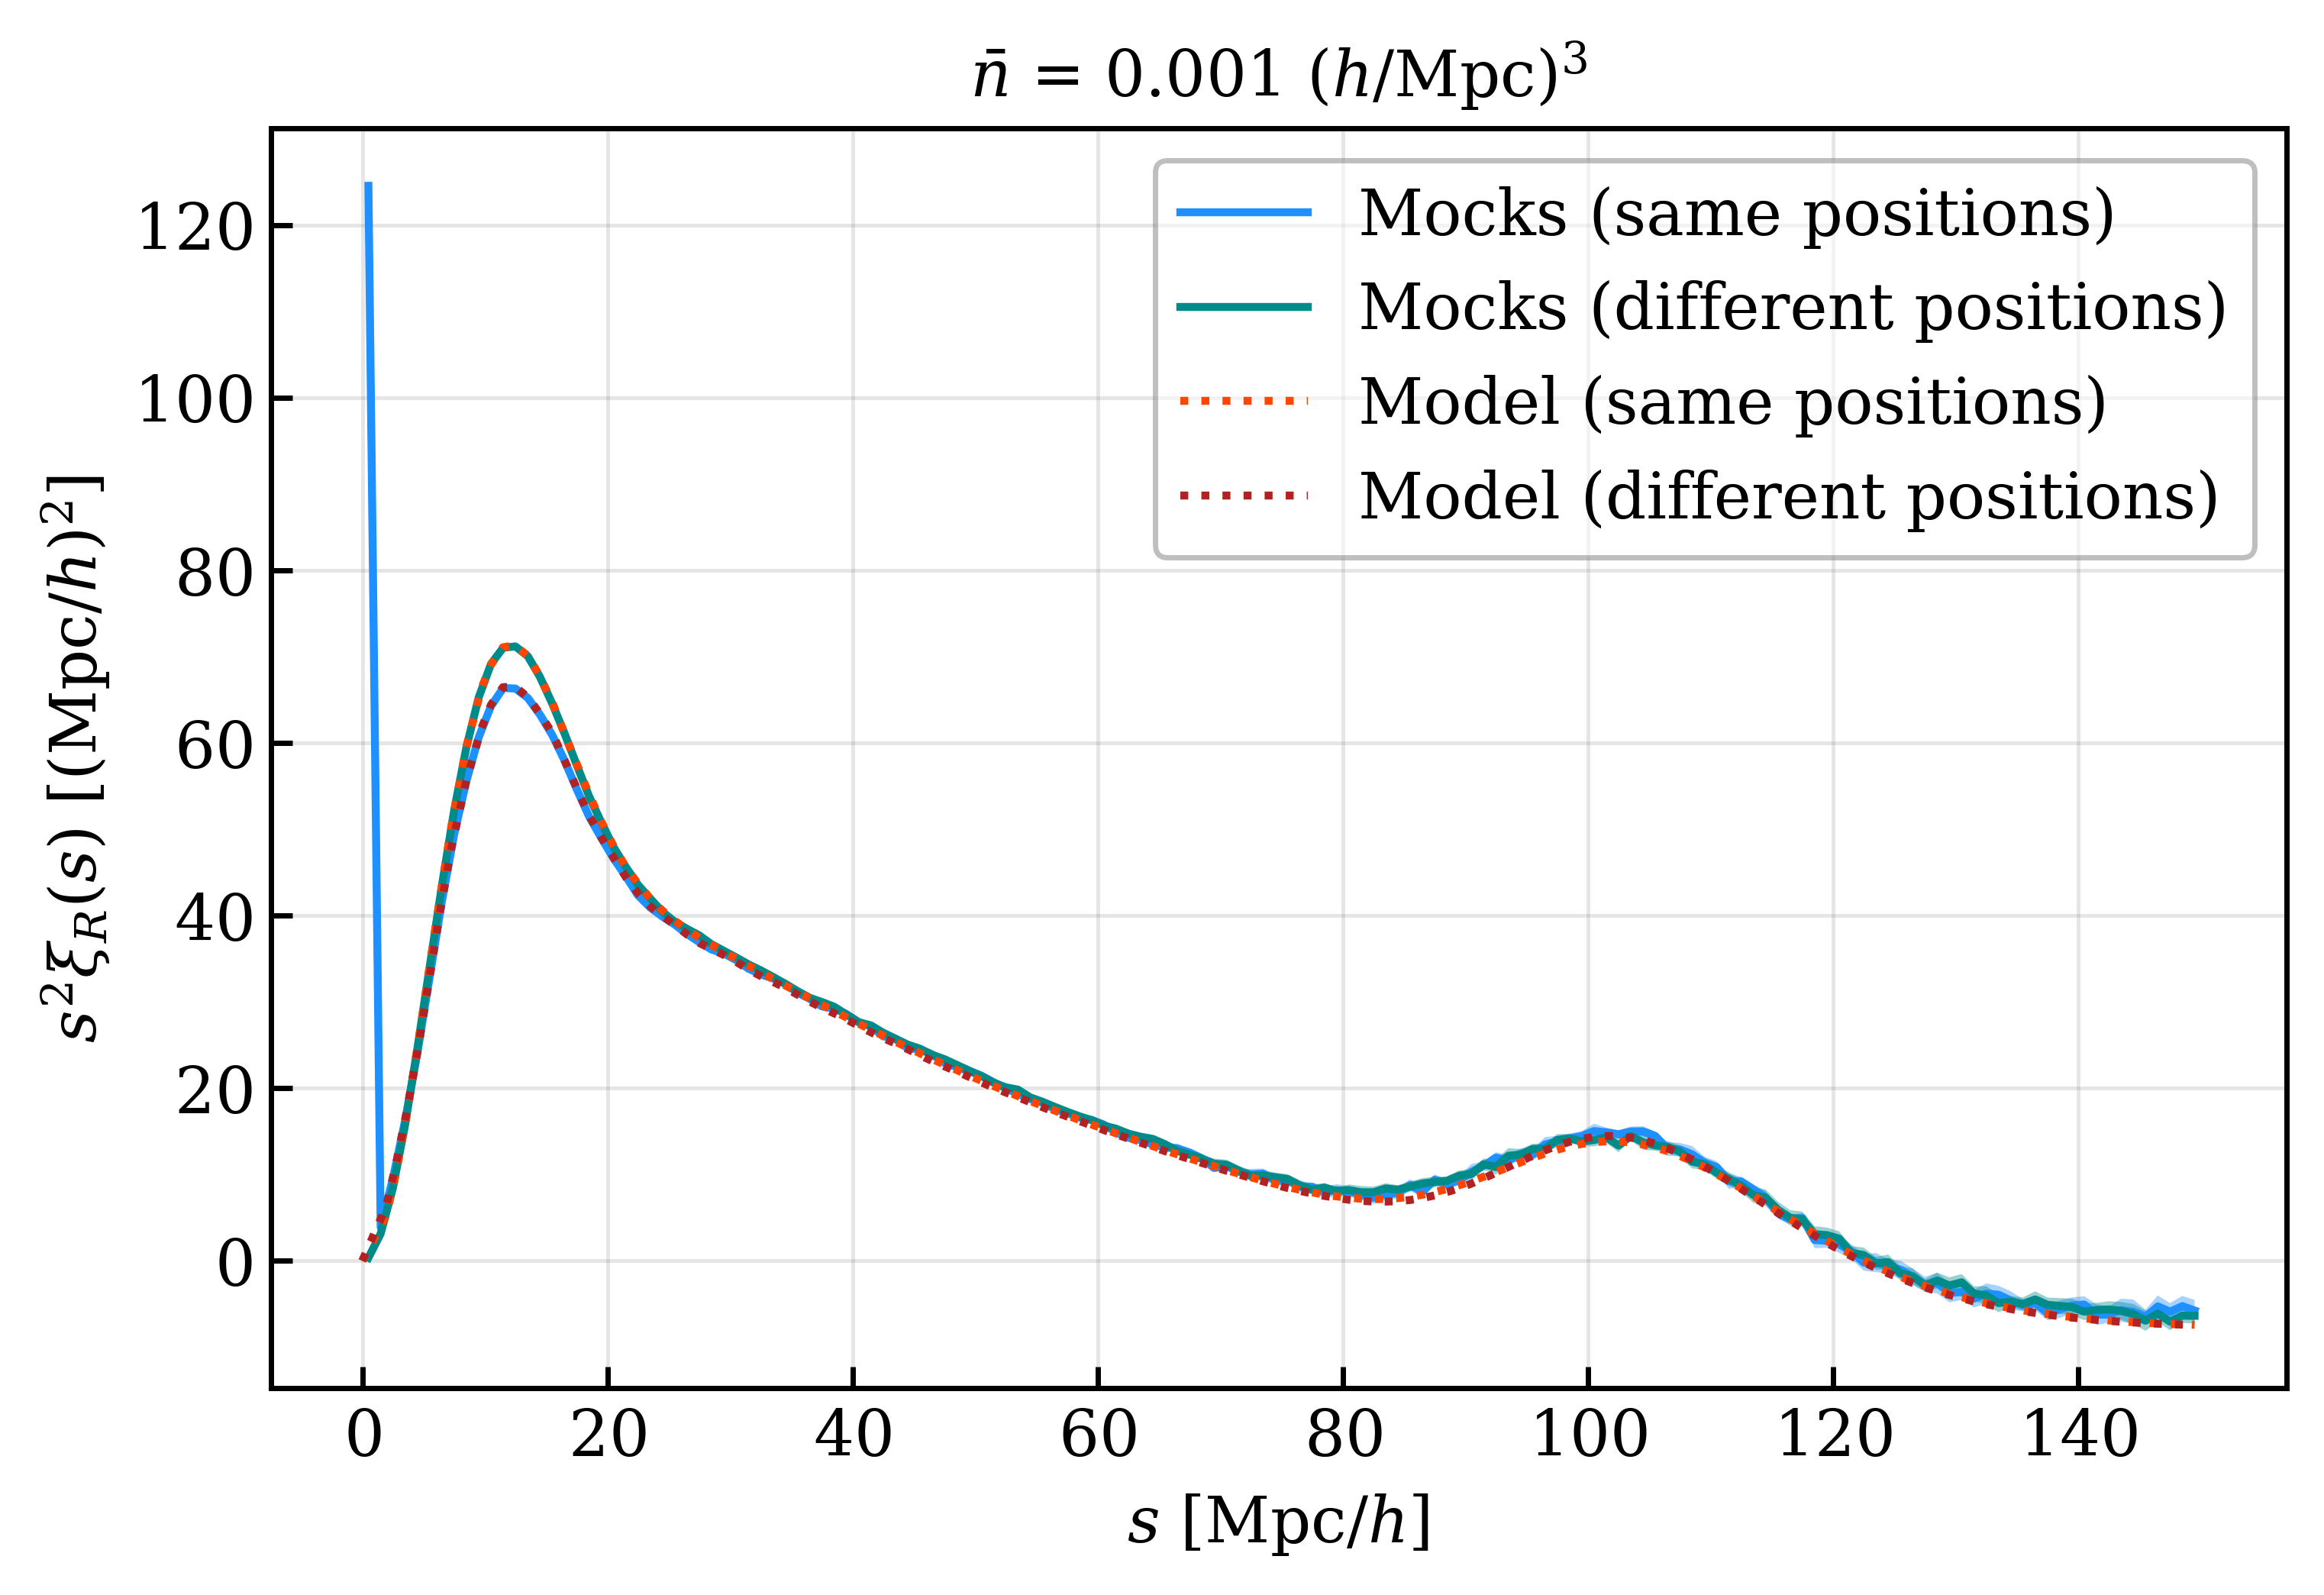

In [62]:
plt.rcParams["figure.figsize"] = (6, 4)

## Mocks
mocks_xi_ells, cov = get_poles(xi_result, ells)
std = np.array(np.array_split(np.diag(cov)**0.5, nells))/np.sqrt(10)
s, _, res = xi_result[0].get_corr(return_sep=True)

mocks_xi_ells2, cov2 = get_poles(xi_result2, ells)
std2 = np.array(np.array_split(np.diag(cov2)**0.5, nells))/np.sqrt(10)
s2, _, res = xi_result[0].get_corr(return_sep=True)

## Model
model_xi = model[i].xi_R_with_shot_noise

for ill, ell in enumerate(ells):
    y = s**2 * mocks_xi_ells[ill]
    error = s**2 * std[ill]
    
    y2 = s2**2 * mocks_xi_ells2[ill]
    error2 = s2**2 * std2[ill]

    plt.plot(s, y, label='Mocks (same positions)', color='dodgerblue') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    plt.fill_between(s, y-error, y+error, alpha=0.4, facecolor='dodgerblue')
    plt.plot(s2, y2, label='Mocks (different positions)', color='darkcyan') # ($\bar{{n}}$ = {:.1e})'.format(nbar))
    plt.fill_between(s2, y2-error2, y2+error2, alpha=0.4, facecolor='darkcyan')
    plt.plot(model[i].sep, model[i].sep**2 * model_xi, label=r'Model (same positions)', ls=':', color='orangered')
    plt.plot(model[i].sep, model[i].sep**2 * xiR_test, label=r'Model (different positions)', ls=':', color='firebrick')
    plt.title(r'$\bar{{n}}$ = {:.3f} $(h/\mathrm{{Mpc}})^3$'.format(nb))

plt.ylabel(r'$s^2 \xi_R(s)$ [$(\mathrm{Mpc}/h)^{2}$]')
plt.xlabel(r'$s$ [$\mathrm{Mpc}/h$]')
plt.legend()
plt.show()

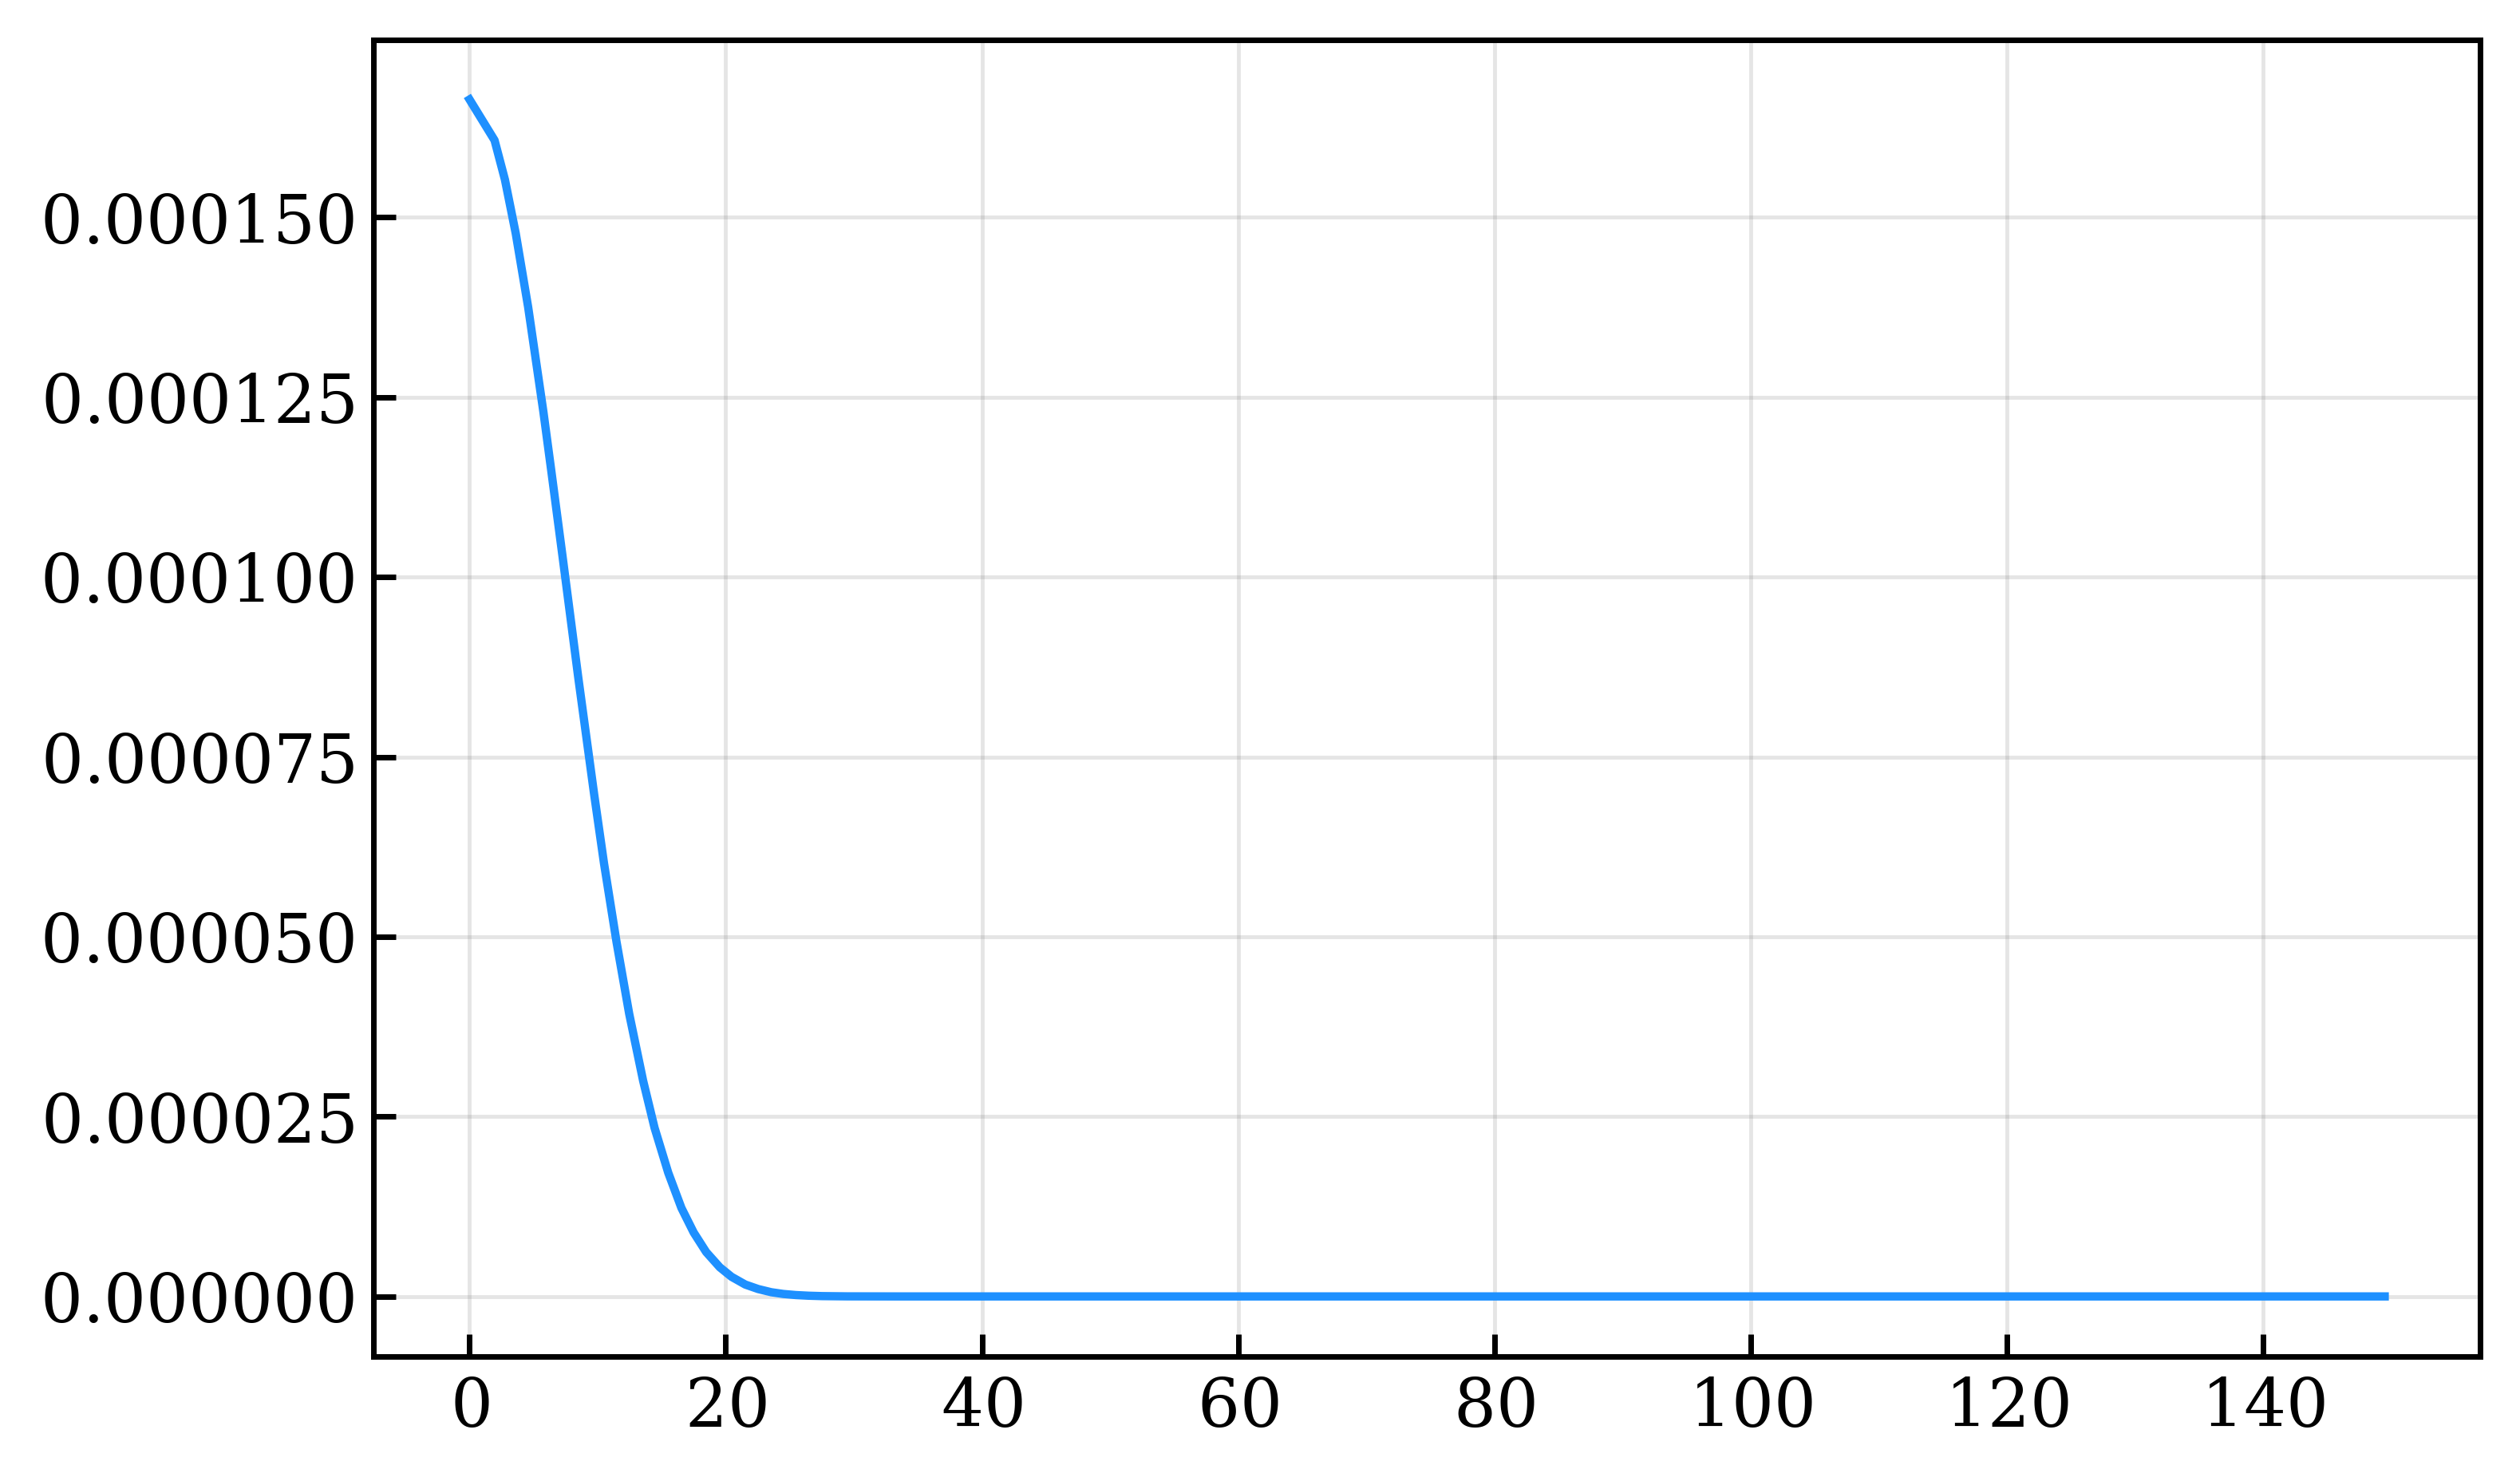

In [64]:
plt.plot(model[i].sep, w)
plt.show()